# Road User Classification
by Kuanchieh Peng

## Problem Statement
> Build a best feasible model that will be later used to classify road users in real time. **The top priorities are: maximizing classification accuracy on unseen data and minimizing prediction speed**.

## Background
> Automatic emergency braking (AEB) system on cars brakes automatically when sensing possible collision with another road user. AEB is designed to reduce vehicle speed the most when sensing collision with cars, then bikers, finally reduces vehicle speed the least when sensing collision with pedestrians. Therefore, **in this project, we especially don't want to misclassify an actual car as another type of road user**.

## Steps
- **EDA & Preprocessing**
    - Cleaning
        - Handling outliers
        - Converting independent and dependent variables into desired data types
    - Transformation
        - Uninvariate displots and boxplots to spot skewness
    - Scaling
    - Checking Multicollinearity
        - Bivariate correlation heatmaps and pairplots to understand pairwise correlations
    - Checking Linear Separability
        - Training a hard margin linear SVC to test linear separability
- **Model Selection**
- **Evaluation Metric Selection**
- **Modeling**
    - Logistic Regression
    - XGBoost
- **Evaluation**
    - F-Beta Score
    - Prediction Speed
    - ROC curve (AUC)

## Sources
- Dataset is "Mobile Accelerometer Car 12K" from Kaggle.
- Background information derived from "City Safety, 2020 XC90 owner's manual" from Volvo.

## Imports

In [1]:
# for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# for modeling
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from hyperopt import hp
from sklearn.model_selection import RepeatedStratifiedKFold

# for evaluation
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import time

# for suppressing system warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

In [2]:
df = pd.read_csv('vrudata.csv')
original_df = df.copy()

## Pipeline

In [37]:
class bold:
    start = '\033[1m'
    end   = '\033[0m'

def information(df):
    # Prints typically useful statistical information about given dataframe.
    print("This dataframe consists of ", df.shape[1], " columns and", df.shape[0], " rows.")
    print("This dataframe consists of ", df.isnull().sum().sum(), " null entires.")
    print("This dataframe consists of ", df[df.duplicated()].shape[0], " duplicate rows.")
    print(df[df['target'] == 1].shape[0], " rows belong to class target = 1.")
    print(df[df['target'] == 0].shape[0], " rows belong to class target = 0.")
    print("")
    print(bold.start, "Notable statistics of numeric features in this dataset:", bold.end)
    print("")
    print(df.describe())
    print("")
    print(bold.start, "Object type of features in this dataset:", bold.end)
    print("")
    df.info()
    
def dist_box(x, title = ''):
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (14.4, 7.2))
    for ax in axes:
        sns.kdeplot(x, shade = False, ax = ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = x.mean()
            sdev = x.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Mean and SD')
        else:
            left, middle, right = np.percentile(x, [25, 50, 75])
            ax.set_title('Median and Quartiles')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), ls = ':')
        ax.fill_between(xs, 0, ys, alpha = 0.2)
        ax.fill_between(xs, 0, ys, where = (left <= xs) & (xs <= right), interpolate = True, alpha = 0.2)
    fig.suptitle(title, fontsize = 16)
    plt.show()
    
def three_d_scatter(df, target = 'target'):
    fig = plt.figure(figsize = (14.4, 10.8))
    ax = fig.add_subplot(111, projection = '3d')
    df_target1 = df[df[target] == 1]
    df_target0 = df[df[target] == 0]
    legend_properties = {}

    ax.scatter(df_target1['acc_x'], df_target1['acc_y'], df_target1['acc_z'], marker = 'x', label = 'Cars')
    ax.scatter(df_target0['acc_x'], df_target0['acc_y'], df_target0['acc_z'], marker = 'o', label = 'Non Cars')
    plt.legend(loc = 'best', prop = legend_properties)
    plt.show()
    
space = {'learning_rate' : hp.uniform('learning_rate', 0, 1),
        'max_depth' : hp.uniform('max_depth', 4, 10),
        'n_estimators' : hp.uniform('n_estimators', 100, 200),
        'gamma': hp.uniform ('gamma', 1, 9),
        'colsample_bytree' : hp.choice('colsample_bytree', [1]),
        'seed' : 60}
    
def xgb_objective(space):
    clf = xgb.XGBClassifier(
        learning_rate = space
        max_depth = int(space['max_depth']),
        n_estimators = space['n_estimators'],
        objective = space['objective'],
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight = int(space['min_child_weight']),
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set = evaluation, eval_metric = "auc",
            early_stopping_rounds = 10, verbose = True)    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    return {'loss': -accuracy, 'status': STATUS_OK }

def f_score(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.round(y_pred))
    return 'f1_err', err
    
def evaluate(ytest, y_pred, speed):
    confusion = confusion_matrix(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, average = 'binary', beta = 1.2)
    print(bold.start, "Classification Report:", bold.end)
    print("")
    print(classification_report(y_test, y_pred))
    print(bold.start, "F - 1.2 Score:", bold.end)
    print("")
    print("{:.6f}".format(fbeta))
    print("")
    print(bold.start, "Prediction speed:", bold.end)
    print("")
    print("{:.6f} seconds".format(speed))
    
def roc(model_string, y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize = (9.6, 7.2))
    plt.grid()
    plt.plot(fpr, tpr, label = model_string + ' (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = "best")
    plt.show()

## EDA

In [4]:
df.head(3)

,acc_x,acc_y,acc_z,target
0,-0.113725,0.083797,9.654618,not car
1,-0.098162,0.087388,9.630676,not car
2,-0.099359,0.094571,9.645041,not car


### Cleaning

In [5]:
information(df)

This dataframe consists of  4  columns and 120000  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  8186  duplicate rows.
0  rows belong to class target = 1.
0  rows belong to class target = 0.

 Notable statistics of numeric features in this dataset: 

               acc_x          acc_y          acc_z
count  120000.000000  120000.000000  120000.000000
mean       -0.354549       5.367115       6.729311
std         1.931744       3.420114       2.588606
min       -12.509735     -19.051361     -19.093689
25%        -1.116619       1.902695       4.829160
50%        -0.529119       6.922834       6.459327
75%        -0.092177       8.182184       9.212952
max        36.782090      13.737244      60.973206

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   acc_x   120000 non-nu

- There are no missing values in the dataframe.
- The three features acc_x, acc_y, acc_z are in desired data type (float, instead of string like object).
- Notable statistic: The data has perfectly balanced classes.
- Our target variable is categorical; map not_car, car to values 0, 1.

In [6]:
df = pd.read_csv('vrudata.csv')
encoder = {'not car' : 0, 'car' : 1}
df['target'].replace(encoder, inplace = True)
df.head(3)

,acc_x,acc_y,acc_z,target
0,-0.113725,0.083797,9.654618,0
1,-0.098162,0.087388,9.630676,0
2,-0.099359,0.094571,9.645041,0


### Transformation
- Use df.skew() to determine whether our features are skewed, meaning whether transformation is neeeded.
- Visualization using distplot-boxplot combined plots for better interpretability.

In [7]:
df.skew(axis = 0)

acc_x     5.031114
acc_y    -0.793934
acc_z    -0.329718
target    0.000000
dtype: float64

- acc_x has large skewness therefore needs transformation. Skewness of acc_y, acc_z are fine.

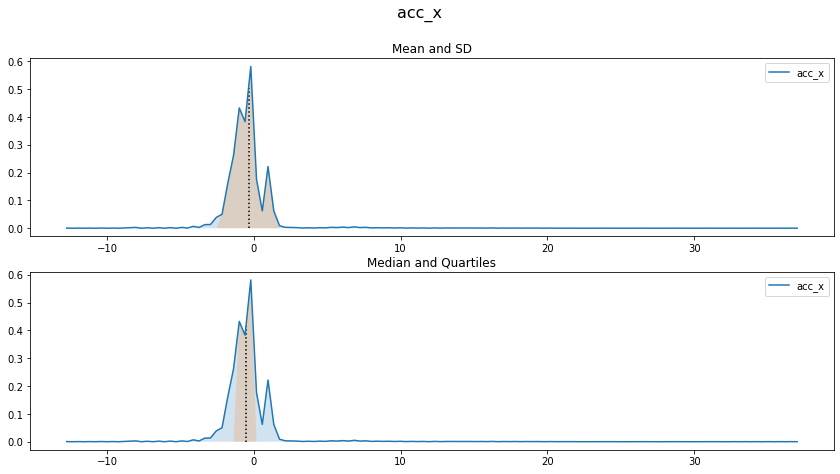

In [8]:
dist_box(df['acc_x'], 'acc_x')

- acc_x is right skewed. Perform log transformation on the data.

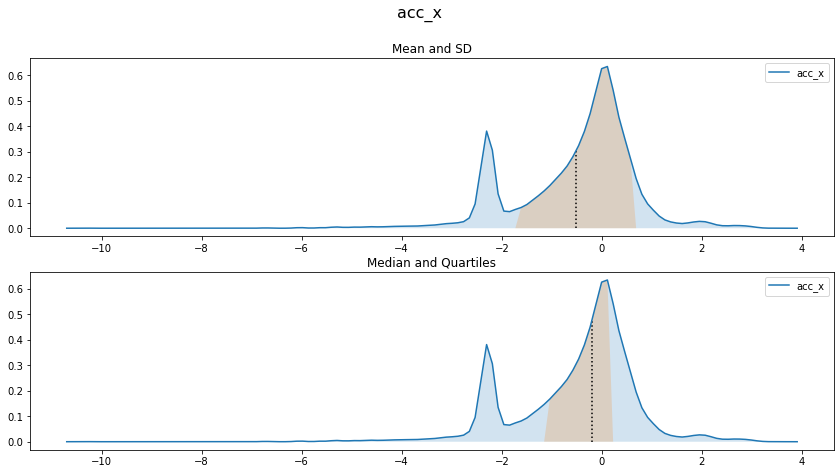

In [9]:
df['acc_x'] = np.log(abs(original_df['acc_x']))
dist_box(df['acc_x'], 'acc_x')

In [10]:
df.skew(axis = 0)

acc_x    -0.868861
acc_y    -0.793934
acc_z    -0.329718
target    0.000000
dtype: float64

- Skewness in acc_x is nonw acceptale and much better than before.

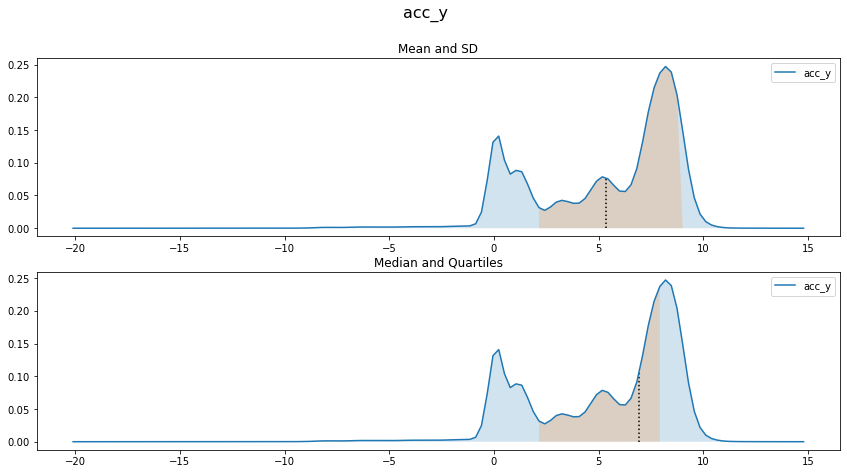

In [11]:
dist_box(df['acc_y'], 'acc_y')

- accy is only slgihtly (skew coefficient < 1) but obviously left skewed (apparently mean < median < mode).

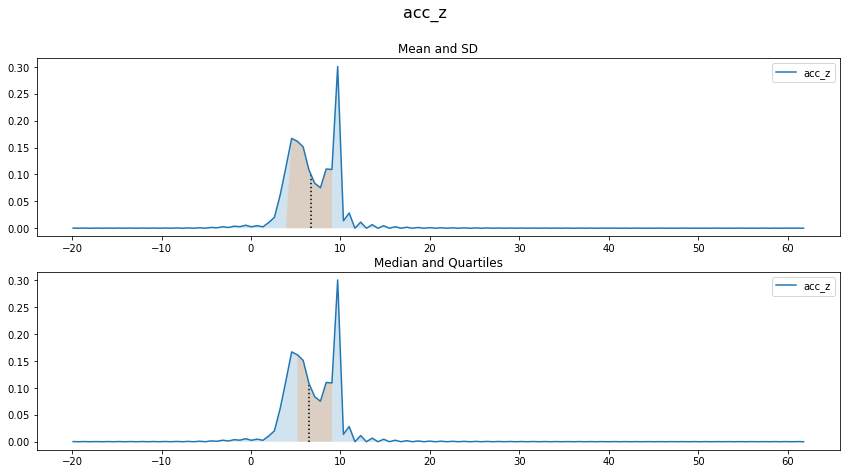

In [12]:
dist_box(df['acc_z'], 'acc_z')

### Scaling
- Our features are not normally distributed but has no outliers. Therefore, use min-max scaler.

In [13]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head(3)

,acc_x,acc_y,acc_z,target
0,0.587281,0.583592,0.359054,0.0
1,0.576771,0.583701,0.358755,0.0
2,0.577637,0.583920,0.358934,0.0


### Checking Multicollinearity

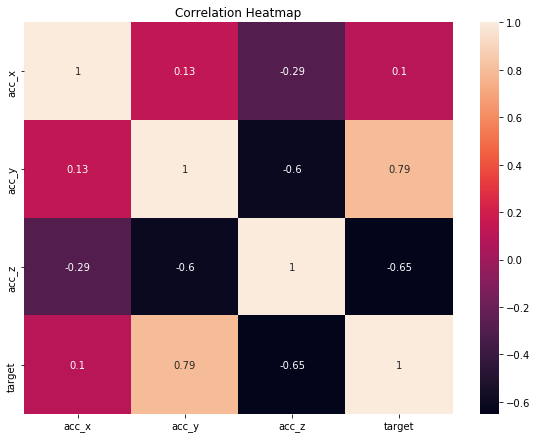

In [14]:
corr = df.corr()
plt.figure(figsize = (9.6, 7.2))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)
plt.title("Correlation Heatmap")
plt.show()

- The correlation between acc_y and acc_z is -0.6, rather strong, meaning there is some multicollinearity in the dataset. Consider removing one of the two variables if using logistic regression.
- acc_y highly correlated to target variables. Reasonable explanation: cars can achieve much larger accelerations on forawrd-backward motions (which is the y-axis for accelerometer on phone, determined by how road users place phone) compared to pedestrains or bikers.

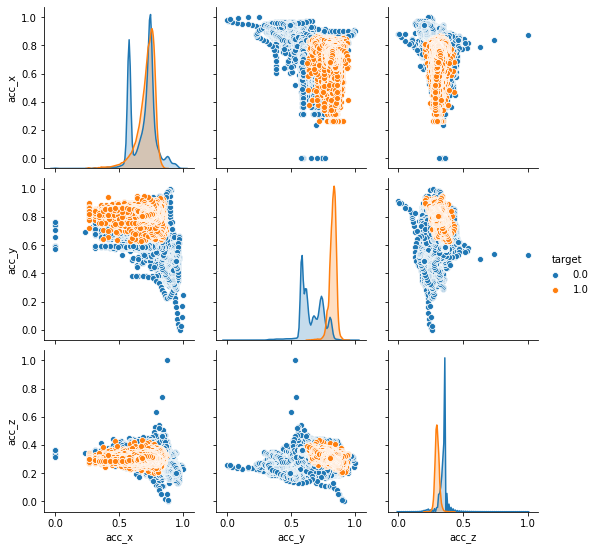

In [15]:
sns.pairplot(df, hue = 'target')
plt.show()

### Checking Linear Separability

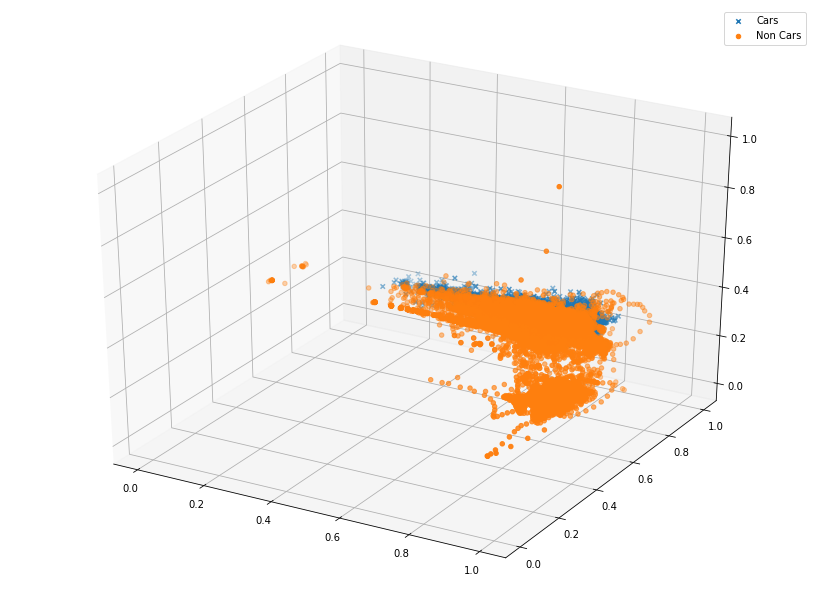

In [16]:
three_d_scatter(df, target = 'target')

- According to the 3-D graph above, data of the two classes might be linearly separable.
- In the following block, to determine whether the data is linearly separable, I trained a hard margin SVC with the data. If the training is able to find a margin for the hard margin SVM, the data is linearly separable; vice versa.
- I used a linear SVC with the regularization parameter C set to infinity for the hard margin SVC desired. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. When C is set a infininty, we get a hard margin SVM.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df[{'acc_x', 'acc_y', 'acc_z'}],
                                                   df['target'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [18]:
svc = make_pipeline(StandardScaler(), LinearSVC(C = float('inf'), max_iter = 1000))
svc.fit(X_train, y_train)
print("Training accuracy:", svc.score(X_train, y_train))

Training accuracy: 0.8061041666666666


C:\Users\kuanc\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [19]:
print("Accuracy:", svc.score(X_test, y_test))

Accuracy: 0.8060416666666667


- The hard margin SVC found a margin and did not overfit. As a result, the data is linearly separable.

## Model Selection
>We want to prioritize getting the best **classification accuracy on unknown data** and  **classification speed**. We can sacrifice training speed and interpretability of the model since the model will be used by vehicles on roads in real time.

>The entire dataset consists of 3 continuous feature columns, 1 categorical target column, and 120,000 rows. That is, we have a **small feature set** and a **large dataset**. There are no missing or questionable values in the dataset. The distribution of the transformed three variables are still slightly **skewed** left, right, and right in the order acc_x, acc_y, and acc_z. There are **no outliers** in any of the three. Data of the two classes are **linearly separable.**

I will use **logistic regression** as my baseline model. The reasons I think logistic regression would serve as a great baseline model in this project are:
1. It is efficient to train.
2. It tends to work well andnot overfit with low dimensional datasets like ours.
3. Works since our dataset is linearly separable.

I will use **XGBoost** as my expected best performing model. The reasons I think XGBoost is the better choice over other boosting and bagging algorithms such as random forest are:
1. Much better prediction speed compared to bagging algorithms.
2. Great accuracy performance as it pushes the limit of computation resources for boosted tree algorithms.
3. Sophisticated but not prone to overfitting as long as parameters are tuned properly.
4. Handles large datasets well.
5. Difficult to interpret but we can sacrifice interpretability thanks to the background of this project.

Then, I will use SGD for optimization because:
1. We have a large amount of data.

## Evaluation Metric selection
Accuracy is one of our two main concerns. According to our background information, **avoiding type II errors is more important** than avoiding type I error, while we want to avoid both. Therefore, I will use F-beta score with beta = 1.2 to evaluate the accuracy performance of our model.

Prediction speed is the other main concern. I will use pandas library "time" to assess the prediction speed performance of our model.

## Logistic Regression

### Feature Selection
- Reminder: The correlation between acc_y and acc_z is -0.6. Might have to remove one of the two variables to make sure the model has little to no multicollinearity (one of the assumptions of logistic regression).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df[{'acc_x', 'acc_y', 'acc_z'}],
                                                   df['target'],
                                                   test_size = 0.2,
                                                   random_state = 60)

In [29]:
X_train['intercept'] = 1
logit = sm.Logit(y_train, X_train)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.196854
         Iterations 9


In [30]:
X_train = X_train.drop('intercept', axis = 1)
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.716     
Dependent Variable: target           AIC:              37803.8907
Date:               2021-12-08 15:26 BIC:              37841.7791
No. Observations:   96000            Log-Likelihood:   -18898.   
Df Model:           3                LL-Null:          -66542.   
Df Residuals:       95996            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
acc_z         -14.9531   0.9694 -15.4257 0.0000 -16.8530 -13.0532
acc_x           0.2558   0.1854   1.3795 0.1677  -0.1076   0.6193
acc_y          50.7195   0.5457  92.9398 0.0000  49.6499  51.7891
intercept     -34.8589   0.7069 -49.3130 0.0000 -36.2444 -33.4734
=================================================================

"""

- acc_x has p-value of 0.276 > 0.05. Remove acc_x from our feature set.

In [31]:
X_train_logit = X_train.drop('acc_x', axis = 1)
X_test_logit = X_test.drop('acc_x', axis = 1)

### Fitting the Model

In [32]:
logit = LogisticRegression()
logit.fit(X_train_logit, y_train)

LogisticRegression()

In [33]:
print("Training accuracy: {:.4f}".format(logit.score(X_train_logit, y_train)))

Training accuracy: 0.9287


In [35]:
temp = X_test.drop('acc_x', axis = 1)
#########
start_time = time.time()
logit_y_pred = logit.predict(temp)
logit_speed = time.time() - start_time
#########
del temp

print("Prediction Accuracy: {:.4f}".format(logit.score(X_test_logit, y_test)))

Prediction Accuracy: 0.9297


### Evaluation

In [38]:
evaluate(y_test, logit_y_pred, logit_speed)

 Classification Report: 

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     11992
         1.0       0.90      0.96      0.93     12008

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000

 F - 1.2 Score: 

0.936883

 Prediction speed: 

0.002999 seconds


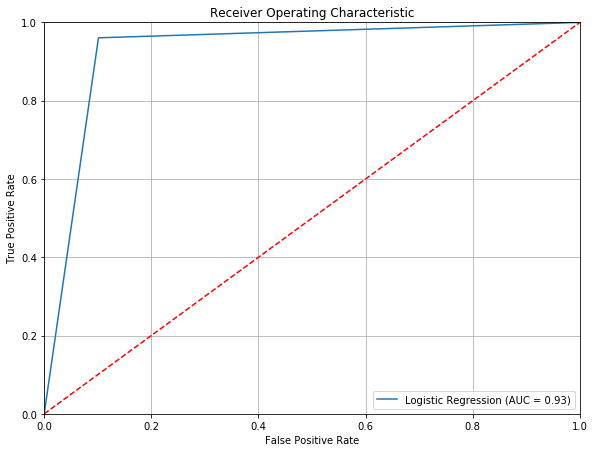

In [39]:
roc('Logistic Regression', y_test, logit_y_pred)

## XGBoost

### Fitting the Model

In [45]:
space = {'learning_rate' : hp.uniform('learning_rate', 0, 1),
        'max_depth' : hp.uniform('max_depth', 4, 10),
        'n_estimators' : hp.quniform('n_estimators', 100, ),
        'gamma': hp.uniform ('gamma', 1, 9),
        'colsample_bytree' : hp.choice('colsample_bytree', [1]),
        'seed' : 60}

In [46]:
xgboost = xgb.XGBClassifier(learning_rate = 0.1, 
                           n_estimators = 200,
                           seed = 60)

xgboost.fit(X_train, y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=60,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=60,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
print("Training accuracy: {:.4f}".format(xgboost.score(X_train, y_train)))

Training accuracy: 0.9474


In [43]:
#########
start_time = time.time()
xgboost_y_pred = xgboost.predict(X_test)
xgboost_speed = time.time() - start_time
#########

print("Prediction Accuracy: {:.4f}".format(xgboost.score(X_test, y_test)))

Prediction Accuracy: 0.9403


In [ ]:
 def xgb_objective(space):
    clf = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),
        n_estimators = space['n_estimators'],
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight = int(space['min_child_weight']),
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set = evaluation, eval_metric = "auc",
            early_stopping_rounds = 10, verbose = True)    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    return {'loss': -accuracy, 'status': STATUS_OK }